### The SIS model - system of two ODEs example
$$
\frac{dS}{dt} = -\frac{\beta SI}{N} + \gamma I\\
\frac{dI}{dt} = \frac{\beta SI}{N} - \gamma I \\
$$
Analytics solution:
$$
I\left(t\right) = \frac{I_{\infty}}{1+V e^{-x t}} \\
S\left(t\right) = N - I\left(t\right),
$$
where $I_{\infty} = \left(1-\gamma/\beta\right)N$, $x = \beta - \gamma$, $V=I_{\infty}/I_{0}-1$

In [ ]:
# Define the actual ODE function for a system of two ODEs
def ode_function(x, y):
    # f1 = dy1/dx, f2 = dy2/dx
    # y = [y1, y2]
    y1 = y[:, 0].reshape(-1,1)
    y2 = y[:, 1].reshape(-1,1)
    if torch.is_tensor(x):
        f1 = torch.cos(x) + y[:, 0] ** 2 + y[:, 1] - (1 + x ** 2 + torch.sin(x) * torch.sin(x))  # dx/dt
        f2 = 2 * x - (1 + x * x) * torch.sin(x) + y[:, 0] * y[:, 1]  # dy/dt
        output = torch.stack((f1, f2), dim=1)
    else:
        print(x)
        print(y[:,0])
        print(y[:,0].reshape(-1, 1))
        f1 = np.cos(x)+(y[:,0])**2+y[:,1]-(1+x**2+np.sin(x)*np.sin(x)) # dx/dt 
        f2 = 2*x-(1+x*x)*np.sin(x) + y[:,0]*y[:,1] # dy/dt
        print(np.shape(x), np.shape(y[:,0]), np.shape(y[:,0].reshape(-1, 1)))
        output = np.array([f1,f2])
    return output

In [236]:
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import autograd.numpy as np # Autograd library allows for automatic differentiation of functions written in Python
from autograd import elementwise_grad as egrad

import seaborn as sns
import matplotlib as mpl
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 100

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import grad

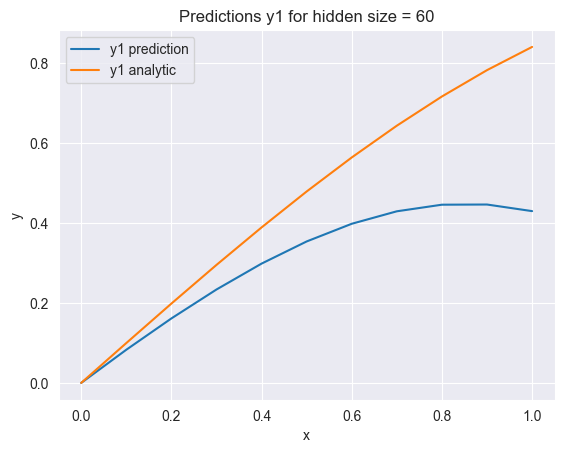

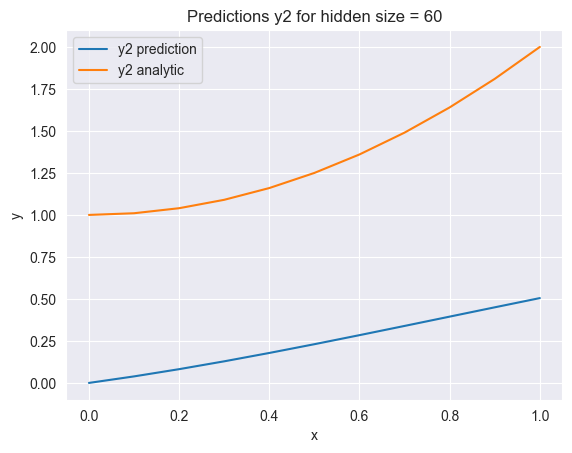

In [262]:
# Define the neural network model for each equation
class PINN_1layer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_1layer, self).__init__()  # getting access to all things from nn.Module
        self.layer1 = nn.Linear(input_size, hidden_size)  # Define the input layer
        self.layer2 = nn.Linear(hidden_size, output_size)  # Define the output layer

    def forward(self, x):
        x_ = torch.sigmoid(self.layer1(x))  # Apply sigmoid activation to the hidden layer
        x_ = self.layer2(x_)  # Output layer - no activation function
        x_ = initial_value + (x - initial_point_of_the_domain) * x_
        return x_
    
# Define the actual ODE function for a system of two ODEs
def ode_function(x, y):
    # f1 = dy1/dx, f2 = dy2/dx
    # y = [y1, y2]
    if torch.is_tensor(x):
        f1 = torch.cos(x) + y[:, 0] ** 2 + y[:, 1] - (1 + x ** 2 + torch.sin(x) * torch.sin(x))  # dx/dt
        f2 = 2 * x - (1 + x * x) * torch.sin(x) + y[:, 0] * y[:, 1]  # dy/dt
        output = torch.stack((f1, f2), dim=1)
    else:
        f1 = np.cos(x)+(y[:,0])**2+y[:,1]-(1+x**2+np.sin(x)*np.sin(x)) # dx/dt 
        f2 = 2*x-(1+x*x)*np.sin(x) + y[:,0]*y[:,1] # dy/dt
        output = np.array([f1,f2])
    return output    

# Define the analytic solution for the system of ODEs
def analytic_solution(x):
    # x - independent variable
#     an_sol = np.zeros((len(x), 2))
#     an_sol[:,0] = np.sin(x)
#     an_sol[:,1] = 1+x*x  
    if torch.is_tensor(x):
        return torch.cat((torch.sin(x), 1 + x * x), dim=1)
    else:
        an_sol = np.concatenate((np.sin(x), 1+x*x), axis=1)
        return an_sol 
    
# Define the loss function for the PINN
def pinn_loss(model1, model2, x_collocation, u_collocation):
    # Convert the input numpy arrays to PyTorch tensors
    x_collocation_tensor = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)

    # Compute the predicted values of u for the collocation points
    u_pred_collocation1 = model1(x_collocation_tensor)  # Predictions for the first equation
    u_pred_collocation2 = model2(x_collocation_tensor)  # Predictions for the second equation

    # Compute the derivatives of u_pred_collocation1 and u_pred_collocation2 with respect to x
    u_pred_derivative1 = torch.autograd.grad(u_pred_collocation1, x_collocation_tensor, grad_outputs=torch.ones_like(u_pred_collocation1), create_graph=True)[0]
    u_pred_derivative2 = torch.autograd.grad(u_pred_collocation2, x_collocation_tensor, grad_outputs=torch.ones_like(u_pred_collocation2), create_graph=True)[0]

    # Compute the loss for each equation separately
    loss_collocation1 = torch.mean((u_pred_derivative1 - ode_function(x_collocation_tensor, analytic_solution(x_collocation_tensor))[:, 0]) ** 2)
    loss_collocation2 = torch.mean((u_pred_derivative2 - ode_function(x_collocation_tensor, analytic_solution(x_collocation_tensor))[:, 1]) ** 2)

    # Total loss as the sum of losses from both equations
    total_loss = loss_collocation1 + loss_collocation2
    return total_loss

# Define the parameters
input_size = 1  # Dimension of the input (x)
output_size = 1  # Dimension of the output (y1 or y2)
initial_value = torch.tensor([0.0, 1.0])  # [y1(a), y2(a)]
initial_point_of_the_domain = 0  # x in (a,b)
hidden_size = 60  # Number of units in the hidden layer

# Create separate instances of the PINN model for each equation
model1 = PINN_1layer(input_size, hidden_size, output_size, initial_value[0], initial_point_of_the_domain)
model2 = PINN_1layer(input_size, hidden_size, output_size, initial_value[1], initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(0, 1, 11).reshape(-1, 1)  # domain (0,1) - 11 sample points as in article
u_collocation = ode_function(x_collocation, analytic_solution(x_collocation))  # Initial condition

# Define the optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

# Training loop
num_epochs = 3000  # as in article - max 100 iter
loss_per_iter = []
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer1.zero_grad()
    optimizer2.zero_grad()

    # Compute the loss
    loss = pinn_loss(model1, model2, x_collocation, u_collocation)

    # Perform optimization
    loss.backward()
    optimizer1.step()
    optimizer2.step()
    
# Evaluate the trained model
with torch.no_grad():
    # Generate test data
    x_test = np.linspace(0, 1, 11).reshape(-1, 1)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    u_pred1 = model1(torch.tensor(x_test, dtype=torch.float32)).detach().numpy()
    u_pred2 = model2(torch.tensor(x_test, dtype=torch.float32)).detach().numpy()

# Compute the analytic solution for comparison
u_analytic = analytic_solution(x_test)

# Plot predictions
plt.plot(x_test, u_pred1[:, 0], label='y1 prediction')
plt.plot(x_test, u_analytic[:, 0], label='y1 analytic')
plt.title('Predictions y1 for hidden size = {}'.format(hidden_size))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


plt.plot(x_test, u_pred2[:, 0], label='y2 prediction')
plt.plot(x_test, u_analytic[:, 1], label='y2 analytic')
plt.title('Predictions y2 for hidden size = {}'.format(hidden_size))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [260]:
# Define the neural network model for each equation
class PINN_1layer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_1layer, self).__init__()  # getting access to all things from nn.Module
        self.layer1 = nn.Linear(input_size, hidden_size)  # Define the input layer
        self.layer2 = nn.Linear(hidden_size, output_size)  # Define the output layer

    def forward(self, x):
        x_ = torch.sigmoid(self.layer1(x))  # Apply sigmoid activation to the hidden layer
        x_ = self.layer2(x_)  # Output layer - no activation function
        x_ = initial_value + (x - initial_point_of_the_domain) * x_
        return x_

In [256]:
# Define the actual ODE function for a system of two ODEs
def ode_function(x, y):
    # f1 = dy1/dx, f2 = dy2/dx
    # y = [y1, y2]
    y1 = y[:, 0].reshape(-1,1)
    y2 = y[:, 1].reshape(-1,1)
    if torch.is_tensor(x):
        f1 = torch.cos(x) + y1 ** 2 + y2 - (1 + x ** 2 + torch.sin(x) * torch.sin(x))  # dx/dt
        f2 = 2 * x - (1 + x * x) * torch.sin(x) + y1 * y2  # dy/dt
        output = torch.stack((f1, f2), dim=1)
    else:
        f1 = np.cos(x)+(y1)**2+y2-(1+x**2+np.sin(x)*np.sin(x)) # dx/dt 
        f2 = 2*x-(1+x*x)*np.sin(x) + y1*y2 # dy/dt
        output = np.array([f1,f2])
    return output

In [257]:
# Define the analytic solution for the system of ODEs
def analytic_solution(x):
    # x - independent variable
#     an_sol = np.zeros((len(x), 2))
#     an_sol[:,0] = np.sin(x)
#     an_sol[:,1] = 1+x*x  
    if torch.is_tensor(x):
        return torch.cat((torch.sin(x), 1 + x * x), dim=1)
    else:
        an_sol = np.concatenate((np.sin(x), 1+x*x), axis=1)
        return an_sol 

In [258]:
# Define the loss function for the PINN
def pinn_loss(model1, model2, x_collocation, u_collocation):
    # Convert the input numpy arrays to PyTorch tensors
    x_collocation_tensor = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)
    u_collocation_tensor = torch.tensor(u_collocation, dtype=torch.float32) # our f(x)

    # Compute the predicted values of u for the collocation points
    u_pred_collocation1 = model1(x_collocation_tensor)  # Predictions for the first equation
    u_pred_collocation2 = model2(x_collocation_tensor)  # Predictions for the second equation

    # Compute the derivatives of u_pred_collocation1 and u_pred_collocation2 with respect to x
    u_pred_derivative1 = torch.autograd.grad(u_pred_collocation1, x_collocation_tensor, grad_outputs=torch.ones_like(u_pred_collocation1), create_graph=True)[0]
    u_pred_derivative2 = torch.autograd.grad(u_pred_collocation2, x_collocation_tensor, grad_outputs=torch.ones_like(u_pred_collocation2), create_graph=True)[0]

    # Compute the loss for each equation separately
    loss_collocation1 = torch.mean((u_pred_derivative1 - ode_function(x_collocation_tensor, analytic_solution(x_collocation_tensor))[:,0]) ** 2)
    loss_collocation2 = torch.mean((u_pred_derivative2 - ode_function(x_collocation_tensor, analytic_solution(x_collocation_tensor))[:,1]) ** 2)

    # Total loss as the sum of losses from both equations
    total_loss = loss_collocation1 + loss_collocation2
    return total_loss

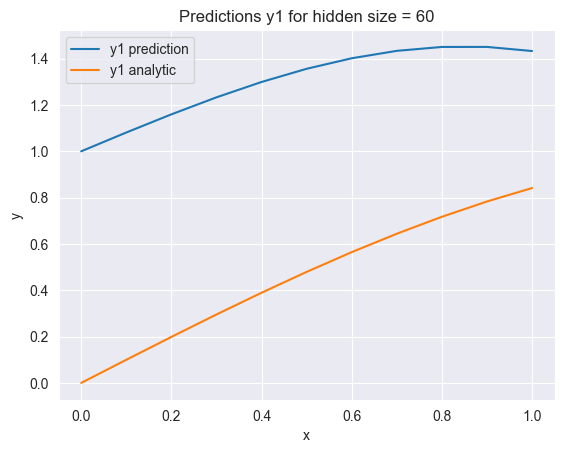

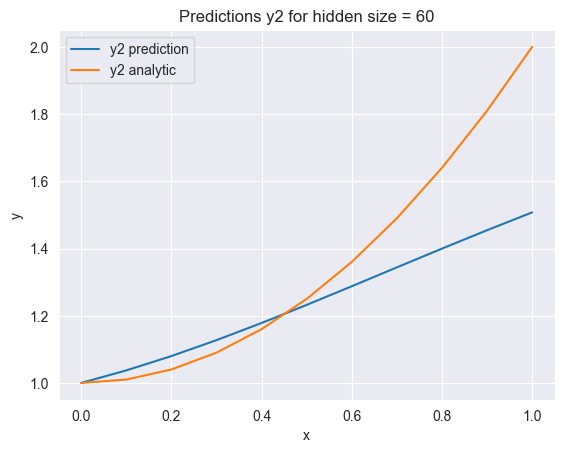

In [267]:
# Define the parameters
input_size = 1  # Dimension of the input (x)
output_size = 1  # Dimension of the output (y1 or y2)
# initial_value = torch.tensor([0.0, 1.0])  # [y1(a), y2(a)]
initial_value_y1 = 0
initial_value_y2 = 1
initial_point_of_the_domain = 0  # x in (a,b)
hidden_size = 60  # Number of units in the hidden layer
number_of_iterations = np.linspace(1, 3000, 3000)

# Create separate instances of the PINN model for each equation
model1 = PINN_1layer(input_size, hidden_size, output_size, initial_value_y1, initial_point_of_the_domain)
model2 = PINN_1layer(input_size, hidden_size, output_size, initial_value_y2, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(0, 1, 11).reshape(-1, 1)  # domain (0,1) - 11 sample points as in article
u_collocation = ode_function(x_collocation, analytic_solution(x_collocation))  # Initial condition

# Define the optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

# Training loop
num_epochs = 3000  # as in article - max 100 iter
loss_per_iter = []
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer1.zero_grad()
    optimizer2.zero_grad()

    # Compute the loss
    loss = pinn_loss(model1, model2, x_collocation, u_collocation)

    # Perform optimization
    loss.backward()
    optimizer1.step()
    optimizer2.step()
    
    loss_per_iter.append(loss.item())  # loss after each iteration
    
# Evaluate the trained model
with torch.no_grad():
    # Generate test data
    x_test = np.linspace(0, 1, 11).reshape(-1, 1)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    u_pred1 = model1(torch.tensor(x_test, dtype=torch.float32)).detach().numpy()
    u_pred2 = model2(torch.tensor(x_test, dtype=torch.float32)).detach().numpy()

# Compute the analytic solution for comparison
u_analytic = analytic_solution(x_test)

# Plot predictions
plt.plot(x_test, u_pred1[:, 1], label='y1 prediction')
plt.plot(x_test, u_analytic[:, 0], label='y1 analytic')
plt.title('Predictions y1 for hidden size = {}'.format(hidden_size))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


plt.plot(x_test, u_pred2[:, 1], label='y2 prediction')
plt.plot(x_test, u_analytic[:, 1], label='y2 analytic')
plt.title('Predictions y2 for hidden size = {}'.format(hidden_size))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

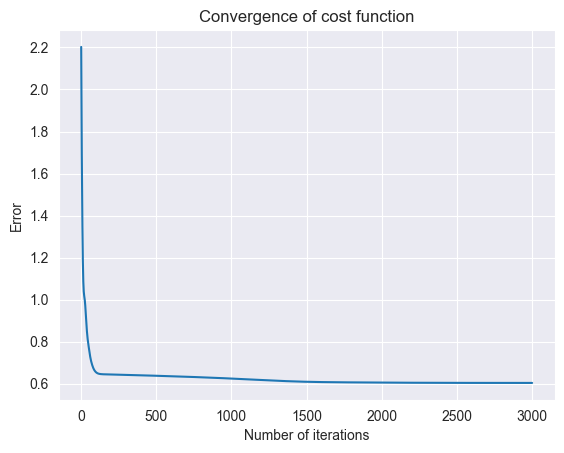

In [269]:
# learning error
plt.plot(number_of_iterations, loss_per_iter)
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.title('Convergence of cost function')
plt.show()